# Plot end of century zonal wind

In [1]:
# Import functions
import warnings 
warnings.filterwarnings('ignore')
import os
import iris
import iris.cube
import cf_units
import numpy as np
import numpy.ma as ma
import xarray as xr
import regionmask
from scipy import stats
import iris.plot as iplt
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import matplotlib.cm as mpl_cm
import matplotlib.colors as colors
from matplotlib.gridspec import GridSpec

ERROR 1: PROJ: proj_create_from_database: Open of /home/h05/awells/.conda/envs/env/share/proj failed


## Load and process wind data

In [2]:
# file path
path = '/data/users/awells/geoMIP/processed_data/UKESM1_Annual_wind_pressure_full_'

ssp245 = xr.open_dataarray(path + 'ssp245_2020-2100.nc')
ssp585 = xr.open_dataarray(path + 'ssp585_2020-2100.nc')
g6con = xr.open_dataarray(path + 'G6controller_2020-2100.nc')
g6sulf = xr.open_dataarray(path + 'G6sulfur_2020-2100.nc')

Calculate end of century average and ensemble mean/zonal mean

In [3]:
ssp245_zonal = ssp245.sel(time=slice('2081','2101')).mean(dim=('time', 'longitude', 'realization'))
ssp585_zonal = ssp585.sel(time=slice('2081','2101')).mean(dim=('time', 'longitude', 'realization'))
g6sulf_zonal = g6sulf.sel(time=slice('2081','2101')).mean(dim=('time', 'longitude', 'realization'))
g6con_zonal = g6con.sel(time=slice('2081','2101')).mean(dim=('time', 'longitude', 'realization'))

## Calculate statistical significance

In [6]:
ssp245_r = ssp245.sel(time=slice('2081','2101')).sel(realization=0)
for i in range(1, len(ssp245.realization)):
    ssp245_r = xr.concat((ssp245_r, ssp245.sel(time=slice('2081','2101')).sel(realization=i)), dim='time')

ssp585_r = ssp585.sel(time=slice('2081','2101')).sel(realization=0)
for i in range(1, len(ssp585.realization)):
    ssp585_r = xr.concat((ssp585_r, ssp585.sel(time=slice('2081','2101')).sel(realization=i)), dim='time')
    
g6sulf_r = g6sulf.sel(time=slice('2081','2101')).sel(realization=0)
for i in range(1, len(g6sulf.realization)):
    g6sulf_r = xr.concat((g6sulf_r, g6sulf.sel(time=slice('2081','2101')).sel(realization=i)), dim='time')
    
g6con_r = g6con.sel(time=slice('2081','2101')).sel(realization=0)
for i in range(1, len(g6con.realization)):
    g6con_r = xr.concat((g6con_r, g6con.sel(time=slice('2081','2101')).sel(realization=i)), dim='time')

In [7]:
stat, pval = stats.ttest_ind(ssp585_r.mean('longitude'), ssp245_r.mean('longitude'))
pval_ssp585 = xr.DataArray(data=pval, 
                     dims=['pressure', 'latitude'], 
                     coords=dict(latitude=(['latitude'], ssp245_r.latitude.values),
                                 pressure=(['pressure'], ssp245_r.pressure.values)))

stat, pval = stats.ttest_ind(g6sulf_r.mean('longitude'), ssp245_r.mean('longitude'))
pval_g6sulf = xr.DataArray(data=pval, 
                     dims=['pressure', 'latitude'], 
                     coords=dict(latitude=(['latitude'], ssp245_r.latitude.values),
                                 pressure=(['pressure'], ssp245_r.pressure.values)))

stat, pval = stats.ttest_ind(g6con_r.mean('longitude'), ssp245_r.mean('longitude'))
pval_g6con = xr.DataArray(data=pval, 
                     dims=['pressure', 'latitude'], 
                     coords=dict(latitude=(['latitude'], ssp245_r.latitude.values),
                                 pressure=(['pressure'], ssp245_r.pressure.values)))

## Load and process tropopause data

In [8]:
# file path
path = '/data/users/awells/geoMIP/processed_data/UKESM1_Annual_tropopause_full_'

ssp245_trop = xr.open_dataarray(path + 'ssp245_2020-2100.nc') / 100  # Pa to hPa
ssp585_trop = xr.open_dataarray(path + 'ssp585_2020-2100.nc') / 100
g6con_trop = xr.open_dataarray(path + 'G6controller_2020-2100.nc') / 100
g6sulf_trop = xr.open_dataarray(path + 'G6sulfur_2020-2100.nc') / 100

Calculate end of century average and ensemble mean/zonal mean

In [9]:
ssp245_trop_zonal = ssp245_trop.sel(time=slice('2081','2101')).mean(dim=('time', 'longitude', 'realization'))
ssp585_trop_zonal = ssp585_trop.sel(time=slice('2081','2101')).mean(dim=('time', 'longitude', 'realization'))
g6sulf_trop_zonal = g6sulf_trop.sel(time=slice('2081','2101')).mean(dim=('time', 'longitude', 'realization'))
g6con_trop_zonal = g6con_trop.sel(time=slice('2081','2101')).mean(dim=('time', 'longitude', 'realization'))

## Plotting

In [15]:
params = {'legend.fontsize': 20,
          'axes.labelsize': 30,
          'axes.titlesize': 30,
          'axes.linewidth': 8,
          'xtick.labelsize': 25,
          'ytick.labelsize': 25,
          'xtick.major.size': 8,
          'ytick.major.size': 8,
          'axes.grid': True}

plt.rcParams.update(params)

def autosize_figure(nrows, ncolumns, scale_factor=1, xscale_factor=1, yscale_factor=1):
    xwidth = (ncolumns+0.67) * 5.0 * scale_factor * xscale_factor
    ylength = (nrows+0.67) * 3.6 * scale_factor * yscale_factor
    return (xwidth, ylength)

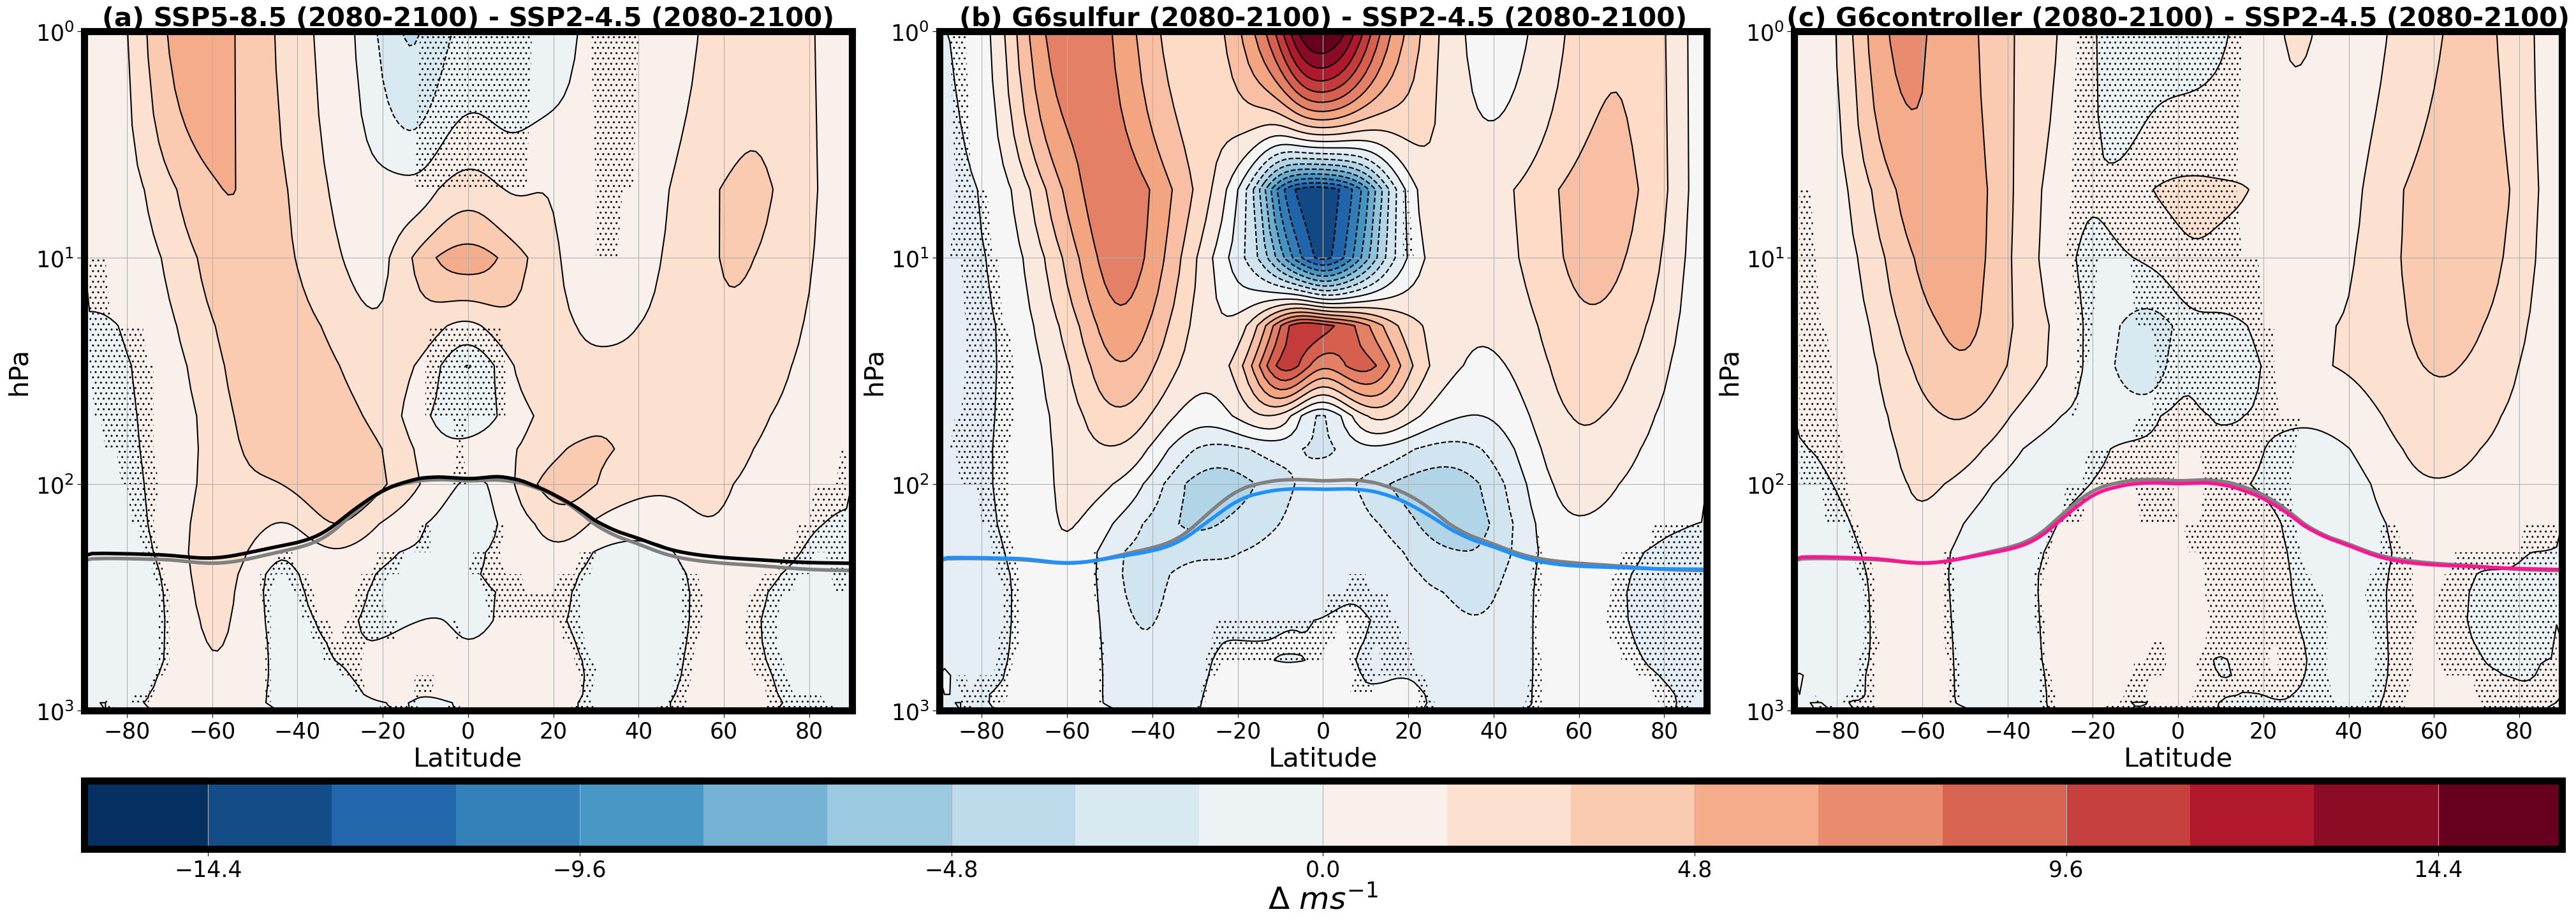

In [17]:
col_map = mpl_cm.get_cmap('RdBu_r')
lvs = np.linspace(-16, 16, 21)
norm = colors.BoundaryNorm(lvs, col_map.N)

fig = plt.figure(figsize=autosize_figure(1, 3, scale_factor=2.2, yscale_factor=1.1))
gs = GridSpec(2, 3, height_ratios=[10, 1])

ax1 = fig.add_subplot(gs[0, 0])
(ssp585_zonal - ssp245_zonal).plot.contourf(levels=lvs, cmap=col_map, add_colorbar=False)
(ssp585_zonal - ssp245_zonal).plot.contour(levels=lvs, colors='k')
ssp245_trop_zonal.plot(color='grey', linewidth=4)
ssp585_trop_zonal.plot(color='k', linewidth=4)
pval_ssp585.where(pval_ssp585>0.05).plot.contourf(colors='none', levels=[0,1], hatches=['..'], add_colorbar=False)
ax1.invert_yaxis()
ax1.set_yscale('log')
plt.ylabel('hPa', fontsize = 30)
plt.xlabel('Latitude', fontsize = 30)
plt.title('(a) SSP5-8.5 (2080-2100) - SSP2-4.5 (2080-2100)', fontweight='bold', fontsize = 30)

ax2 = fig.add_subplot(gs[0, 1])
(g6sulf_zonal - ssp245_zonal).plot.contourf(levels=lvs, cmap=col_map, add_colorbar=False)
(g6sulf_zonal - ssp245_zonal).plot.contour(levels=lvs, colors='k')
ssp245_trop_zonal.plot(color='grey', linewidth=4)
g6sulf_trop_zonal.plot(color='dodgerblue', linewidth=4)
pval_g6sulf.where(pval_g6sulf>0.05).plot.contourf(colors='none', levels=[0,1], hatches=['..'], add_colorbar=False)
ax2.invert_yaxis()
ax2.set_yscale('log')
plt.ylabel('hPa', fontsize = 30)
plt.xlabel('Latitude', fontsize = 30)
plt.title('(b) G6sulfur (2080-2100) - SSP2-4.5 (2080-2100)', fontweight='bold', fontsize = 30)

ax3 = fig.add_subplot(gs[0, 2])
cb = (g6con_zonal - ssp245_zonal).plot.contourf(levels=lvs, cmap=col_map, add_colorbar=False)
(g6con_zonal - ssp245_zonal).plot.contour(levels=lvs, colors='k')
ssp245_trop_zonal.plot(color='grey', linewidth=4)
g6con_trop_zonal.plot(color='deeppink', linewidth=4)
pval_g6con.where(pval_g6con>0.05).plot.contourf(colors='none', levels=[0,1], hatches=['..'], add_colorbar=False)
ax3.invert_yaxis()
ax3.set_yscale('log')
plt.ylabel('hPa', fontsize = 30)
plt.xlabel('Latitude', fontsize = 30)
plt.title('(c) G6controller (2080-2100) - SSP2-4.5 (2080-2100)', fontweight='bold', fontsize = 30)

ax4 = fig.add_subplot(gs[1, :])
col_bar = plt.colorbar(cb, cax=ax4, orientation='horizontal')
col_bar.set_label('$\Delta$ $ms^{-1}$', fontsize = 35)

plt.tight_layout()
plt.savefig('/net/home/h05/awells/PycharmProjects/G6_comparison/Plots/Wells2023/FigureS5.png', dpi=200)
plt.show()